In [1]:
%matplotlib inline
import numpy
from astropy.io import fits
import h5py
from sys import  path
path.append("/home/hkli/work/mylib/")
import tool_box
from plot_tool import Image_Plot
import matplotlib.pyplot as plt
from numpy import fft
from scipy import signal

In [11]:
def gamma_to_kappa(g1, g2):
    sp = g1.shape
    nx, ny = sp[1]*2 +1, sp[0]*2 +1
    cenx, ceny = int(nx / 2), int(ny / 2)

    my, mx = numpy.mgrid[-ceny:ny - ceny, -cenx:nx - cenx]
    print(nx, cenx, my.min(), my.max())
    R2 = my ** 2 + mx ** 2
    D1 = (my ** 2 - mx ** 2) / R2 ** 2
    D2 = -2 * my * mx / R2 ** 2

    D1[ceny, cenx] = 0
    D2[ceny, cenx] = 0

    kappa_1 = signal.convolve(g1, D1, mode="same")
    kappa_2 = signal.convolve(g2, D2, mode="same")

    kappa_ini = numpy.zeros_like(g1) + 0.001

    # while True:
    #     max_kappa_ini = kappa_ini.max()
    #
    #     g1_prime = (1 - kappa_ini)*g1
    #     g2_prime = (1 - kappa_ini)*g2
    #
    #     kappa_1 = signal.convolve(g1_prime, D1, mode="same")
    #     kappa_2 = signal.convolve(g2_prime, D2, mode="same")
    #
    #     kappa_resc = kappa_1 + kappa_2
    #
    #
    #     kappa_ini = kappa_resc
    #
    #     diff_kappa = kappa_resc.max() - max_kappa

    return (kappa_1 + kappa_2)/numpy.pi

10.0
100.0
[[ 0.00000000+3.14159265j -1.88495559+2.51327412j -3.14159265+0.j
  -1.88495559-2.51327412j  0.00000000-3.14159265j]
 [ 1.88495559+2.51327412j  0.00000000+3.14159265j -3.14159265+0.j
   0.00000000-3.14159265j  1.88495559-2.51327412j]
 [ 3.14159265+0.j          3.14159265+0.j          0.00000000+0.j
   3.14159265+0.j          3.14159265+0.j        ]
 [ 1.88495559-2.51327412j  0.00000000-3.14159265j -3.14159265+0.j
   0.00000000+3.14159265j  1.88495559+2.51327412j]
 [ 0.00000000-3.14159265j -1.88495559-2.51327412j -3.14159265+0.j
  -1.88495559+2.51327412j  0.00000000+3.14159265j]]


/home/hkli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/hkli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/hkli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


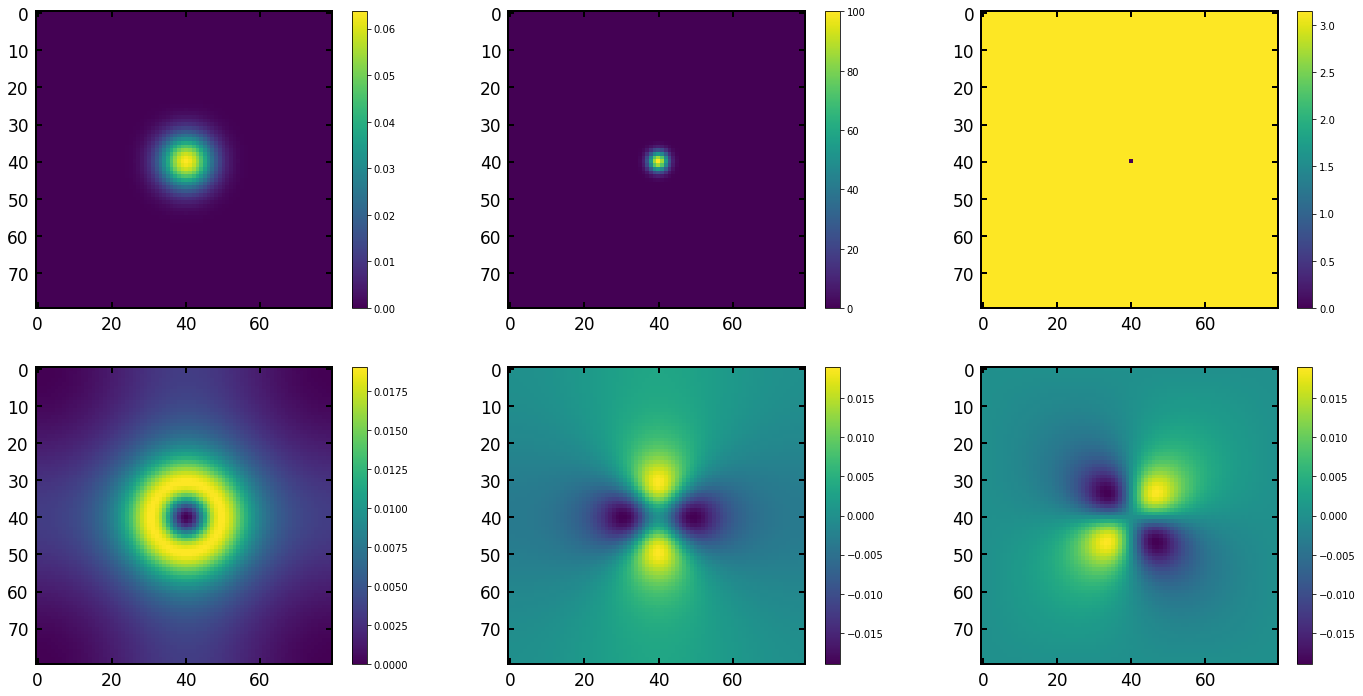

In [13]:
size = 80
cen = int(size/2)
sig = 5
my,mx = numpy.mgrid[0:size,0:size]
ky,kx = my - cen, mx-cen

kappa = 10/numpy.pi/2/sig**2*numpy.exp(-((my-cen)**2+(mx-cen)**2)/2/sig**2)

print(kappa.sum())

kappa_f = fft.fftshift(fft.fft2(kappa))
k_pow = numpy.abs(kappa_f)**2


print(k_pow.max())

D_f = (kx**2 - ky**2 + 2j*ky*kx)/(ky**2 + kx**2)*numpy.pi

nan_ = numpy.isnan(D_f)
npw = numpy.where(nan_ == True)

D_f[cen,cen] = 0+0j

print(D_f[cen-2:cen+3,cen-2:cen+3])

gamma_f = D_f*kappa_f/numpy.pi
gamma = fft.ifft2(fft.ifftshift(gamma_f))

g1, g2 = gamma.real, gamma.imag

gamma_ = g1 + g2*1j
gamma_f = fft.fftshift(fft.fft2(gamma_))
D_f_con = D_f.conjugate()
kappa_f_recon = gamma_f*D_f_con/numpy.pi
kappa_recon = fft.ifft2(fft.ifftshift(kappa_f_recon)).real

g = numpy.abs(gamma)
npw = numpy.where(g == 0)

cos_theta = numpy.sqrt((1+g1/g)/2)
sin_theta = g2/2/g/cos_theta
idx = cos_theta == 0
sin_theta[idx] = 1

img = Image_Plot()
img.create_subfig(2,3)

fig1 = img.axs[0][0].imshow(kappa)
plt.colorbar(fig1, ax=img.axs[0][0])
fig2 = img.axs[0][1].imshow(k_pow)
plt.colorbar(fig2, ax=img.axs[0][1])
fig3 = img.axs[0][2].imshow(numpy.abs(D_f))
plt.colorbar(fig3, ax=img.axs[0][2])

fig1 = img.axs[1][0].imshow(g)
plt.colorbar(fig1, ax=img.axs[1][0])
fig2 = img.axs[1][1].imshow(g1)
plt.colorbar(fig2, ax=img.axs[1][1])
fig3 = img.axs[1][2].imshow(g2)
plt.colorbar(fig3, ax=img.axs[1][2])
img.show_img()



0.0190171522264


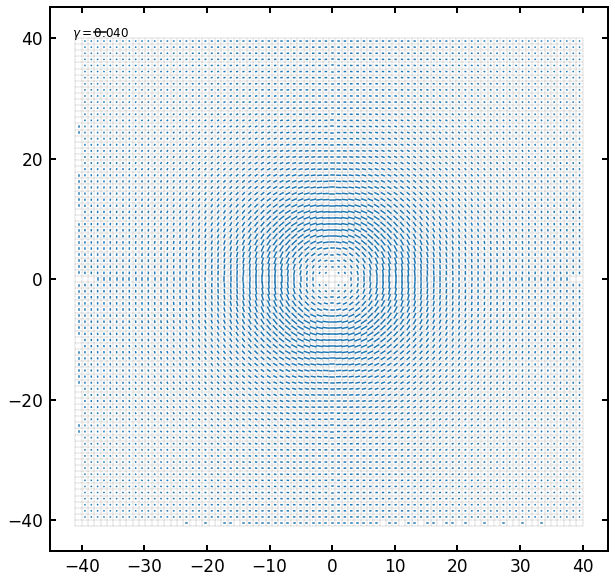

In [14]:
img = Image_Plot(fig_x=10, fig_y=10)
img.create_subfig(1,1)

max_g = g.max()

ra_bin = numpy.linspace(-cen-1, cen, size+1)
dec_bin = numpy.linspace(-cen-1, cen, size+1)

nx,ny = size, size

ra_min, ra_max = ra_bin.min(), ra_bin.max()
dec_min, dec_max = dec_bin.min(), dec_bin.max()

ra_sq_len = ra_bin[2] - ra_bin[1]
dec_sq_len = ra_sq_len
max_len = ra_sq_len*0.9
    
shear_bench = 0.04
scale_len = shear_bench/max_g*max_len
print(max_g)
x1, x2 = ra_min + ra_sq_len*3, ra_min + ra_sq_len*3 + scale_len
y1,y2 = dec_max + dec_sq_len, dec_max + dec_sq_len

img.axs[0][0].plot([x1,x2],[y1,y2],c="black")
img.axs[0][0].text(0.04, 0.95, "$\gamma=%.3f$"%shear_bench, color='black', ha='left',
        va='center', transform=img.axs[0][0].transAxes, fontsize=img.legend_size-5)

for i in range(ny + 1):
    img.axs[0][0].plot([ra_min, ra_max], [dec_bin[i], dec_bin[i]], c="black", linestyle="--",alpha=0.6,linewidth=0.3)
for j in range(nx + 1):
    img.axs[0][0].plot([ra_bin[j], ra_bin[j]], [dec_min, dec_max], c="black",linestyle="--" ,alpha=0.6, linewidth=0.3)
    
dg_scale = g/max_g*max_len/2

for i in range(ny):
    for j in range(nx):
        if g2[i,j] < 0:
            dx = -dg_scale[i,j]*cos_theta[i,j]
            dy = -dg_scale[i,j]*sin_theta[i,j]
        else:
            dx = dg_scale[i, j] * cos_theta[i, j]
            dy = dg_scale[i, j] * sin_theta[i, j]

        x = (ra_bin[j] + ra_bin[j+1])/2
        y = (dec_bin[i] + dec_bin[i+1])/2
        img.axs[0][0].plot([x + dx, x - dx], [y + dy, y - dy], c="C0")
img.show_img()

161 80 -80 80


/home/hkli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/hkli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


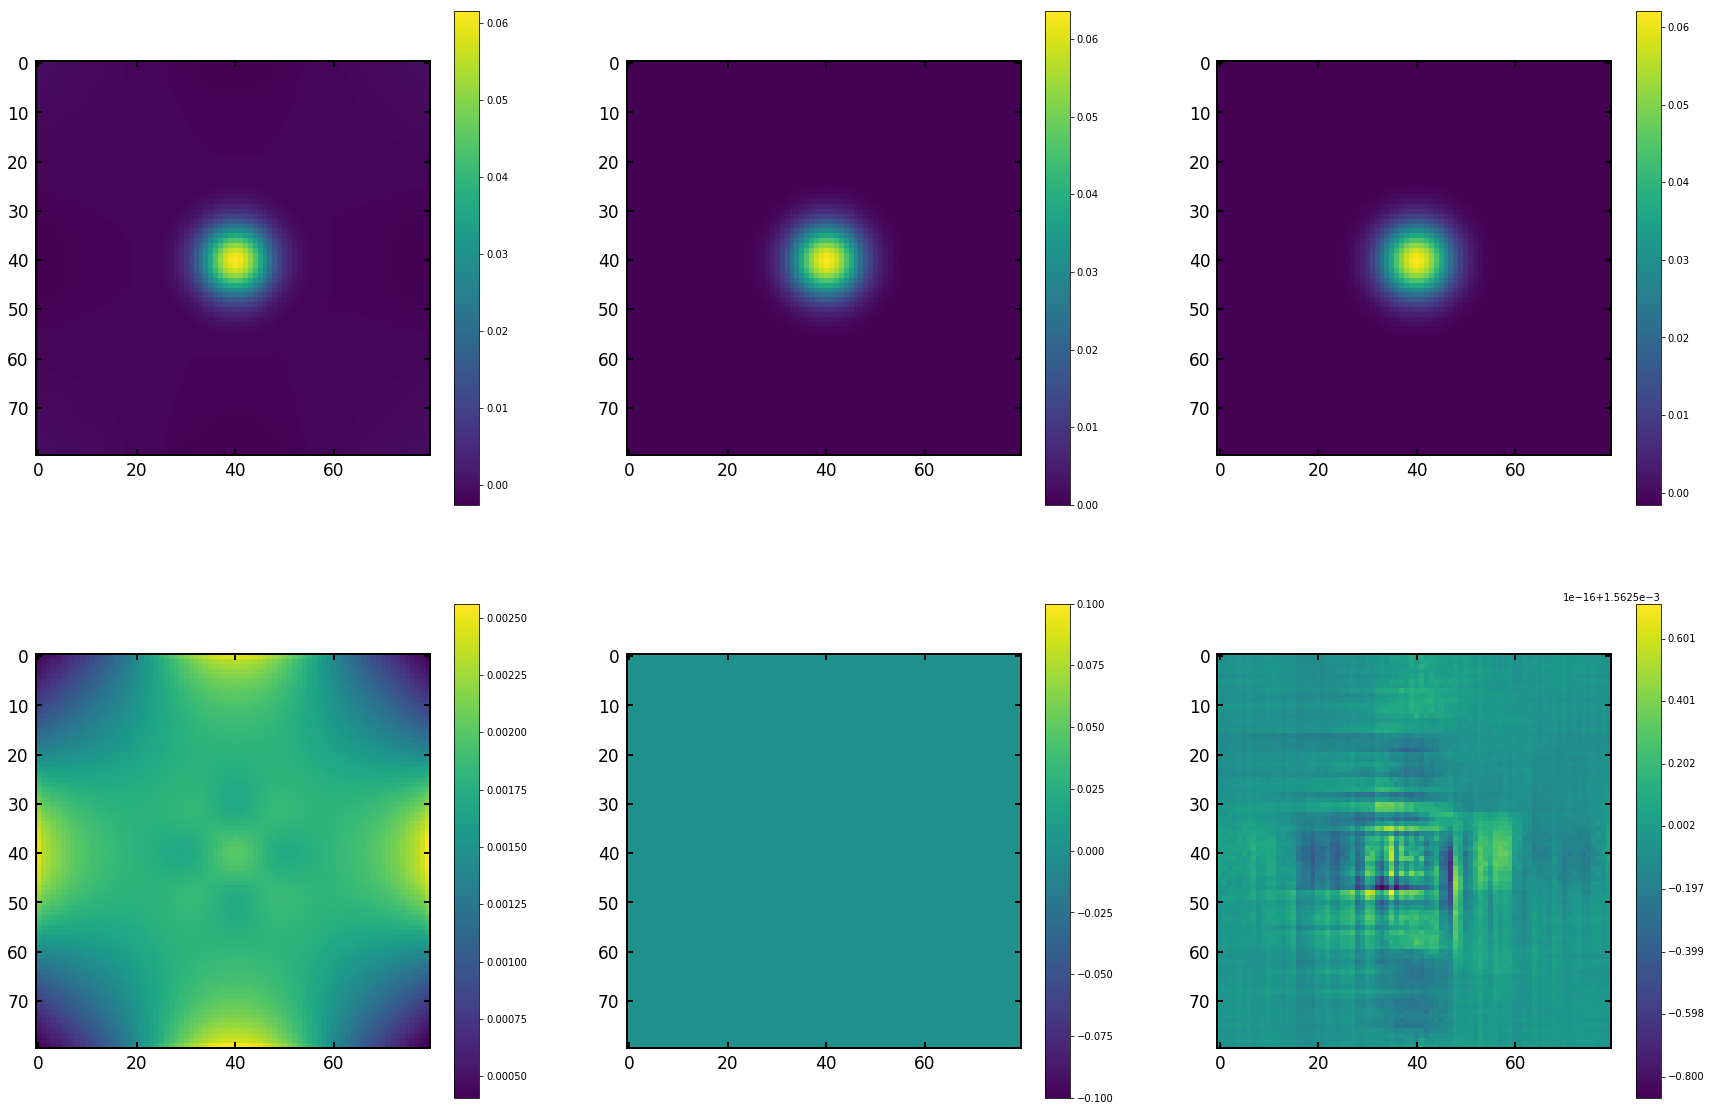

In [15]:
kappa_recon_c = gamma_to_kappa(g1, g2)
plt_data = [[kappa_recon_c, kappa, kappa_recon],
                    [kappa - kappa_recon_c, kappa - kappa, kappa - kappa_recon]]
img = Image_Plot(fig_x=10, fig_y=10)
img.create_subfig(2, 3)

for i in range(2):
    for j in range(3):
        subfig = img.axs[i][j].imshow(plt_data[i][j])
        plt.colorbar(subfig, ax=img.axs[i][j])

img.show_img()

# img = Image_Plot()
# img.create_subfig(2,3)

# fig1 = img.axs[0][0].imshow(kappa)
# plt.colorbar(fig1, ax=img.axs[0][0])

# fig2 = img.axs[0][1].imshow(kappa_recon)
# plt.colorbar(fig2, ax=img.axs[0][1])

# fig3 = img.axs[1][0].imshow(kappa_recon-kappa)
# plt.colorbar(fig3, ax=img.axs[1][0])

# new_kappa = gamma_to_kappa(g1,g2)

# fig4 = img.axs[1][1].imshow(new_kappa)
# plt.colorbar(fig4, ax=img.axs[1][1])
# img.show_img()


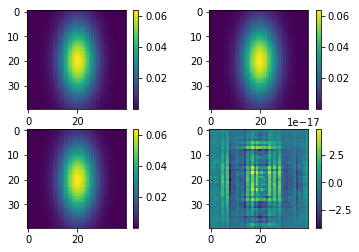

In [39]:
a1 = 10/numpy.pi/2/sig**2*numpy.exp(-((my-cen)**2/4+(mx-cen)**2)/2/sig**2)
a1_f = fft.fftshift(fft.fft2(a1))
a1_if1 = fft.ifft2(fft.ifftshift(a1_f)).real
a1_if2 = fft.ifft2(fft.fftshift(a1_f)).real

plt.subplot(221)
plt.imshow(a1)
plt.colorbar()
plt.subplot(222)
plt.imshow(a1_if1)
plt.colorbar()
plt.subplot(223)
plt.imshow(fft.fftshift(fft.fftshift(a1)))
plt.colorbar()
plt.subplot(224)
plt.imshow(a1-a1_if2)
plt.colorbar()
plt.show()
plt.close()

In [3]:
new_kappa = gamma_to_kappa(g1,g2)
plt.imshow(new_kappa)
plt.colorbar()

NameError: name 'g1' is not defined